In [13]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import sklearn

import torch
import torchvision as vision
from torchvision.utils import make_grid

from hypernevus.models import Autoencoder

In [2]:
output_dir = Path("../output")
assert output_dir.exists()

In [100]:
ckpt_file = output_dir / "epoch-30.ckpt"
assert ckpt_file.exists()

In [101]:
ckpt = torch.load(ckpt_file)

In [102]:
num_bands = 115
autoencoder = Autoencoder(num_bands)
autoencoder.load_state_dict(ckpt["model_state_dict"])

<All keys matched successfully>

In [103]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(115, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(64, 115, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [9]:
data_dir = Path("../data/patches/64")
assert data_dir.exists()

In [38]:
max_bands = 120
band_slice = slice(0, 115)
num_bands = len(range(*band_slice.indices(max_bands)))
print(num_bands)

def loader(file_path):
        hsi = np.load(file_path)
        hsi = hsi[..., band_slice]
        hsi = np.transpose(hsi, axes=[2, 0, 1])
        hsi = np.clip(hsi, 0, 1)
        return hsi

np.random.seed(42)
torch.manual_seed(42)

dataset = vision.datasets.DatasetFolder(str(data_dir), loader, extensions=".npy")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

115


In [108]:
from math import ceil
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure


def make_grid(tensor, ncols=8, vmin=0, vmax=1, cmap="viridis"):
    fig = Figure(figsize=(8, 8), dpi=600)
    canvas = FigureCanvasAgg(fig)

    nrows = ceil(tensor.shape[0] / ncols)

    for image_num, image in enumerate(tensor, start=1):
        ax = fig.add_subplot(nrows, ncols, image_num)
        ax.imshow(image, vmin=vmin, vmax=vmax, cmap=cmap)
        ax.axis("off")

    fig.tight_layout()
    canvas.draw()
    buf = canvas.buffer_rgba()    
    image_grid = np.asarray(buf)
    
    return image_grid

In [107]:
def show_image_grid(image, axes, band=50, vmin=0, vmax=1, cmap="viridis"):
    temp_image = image.detach().cpu()
    temp_image = temp_image[:, band]
    # temp_image = torch.unsqueeze(temp_image, dim=1)
    # temp_image = temp_image.permute(0, 2, 3, 1)
    
    image_grid = make_grid(temp_image, vmin=vmin, vmax=vmax, cmap=cmap)
    # image_grid = np.transpose(image_grid, axes=[1, 2, 0])
    # image_grid = image_grid[..., 0]    
    axes.imshow(image_grid)
    axes.axis("off")

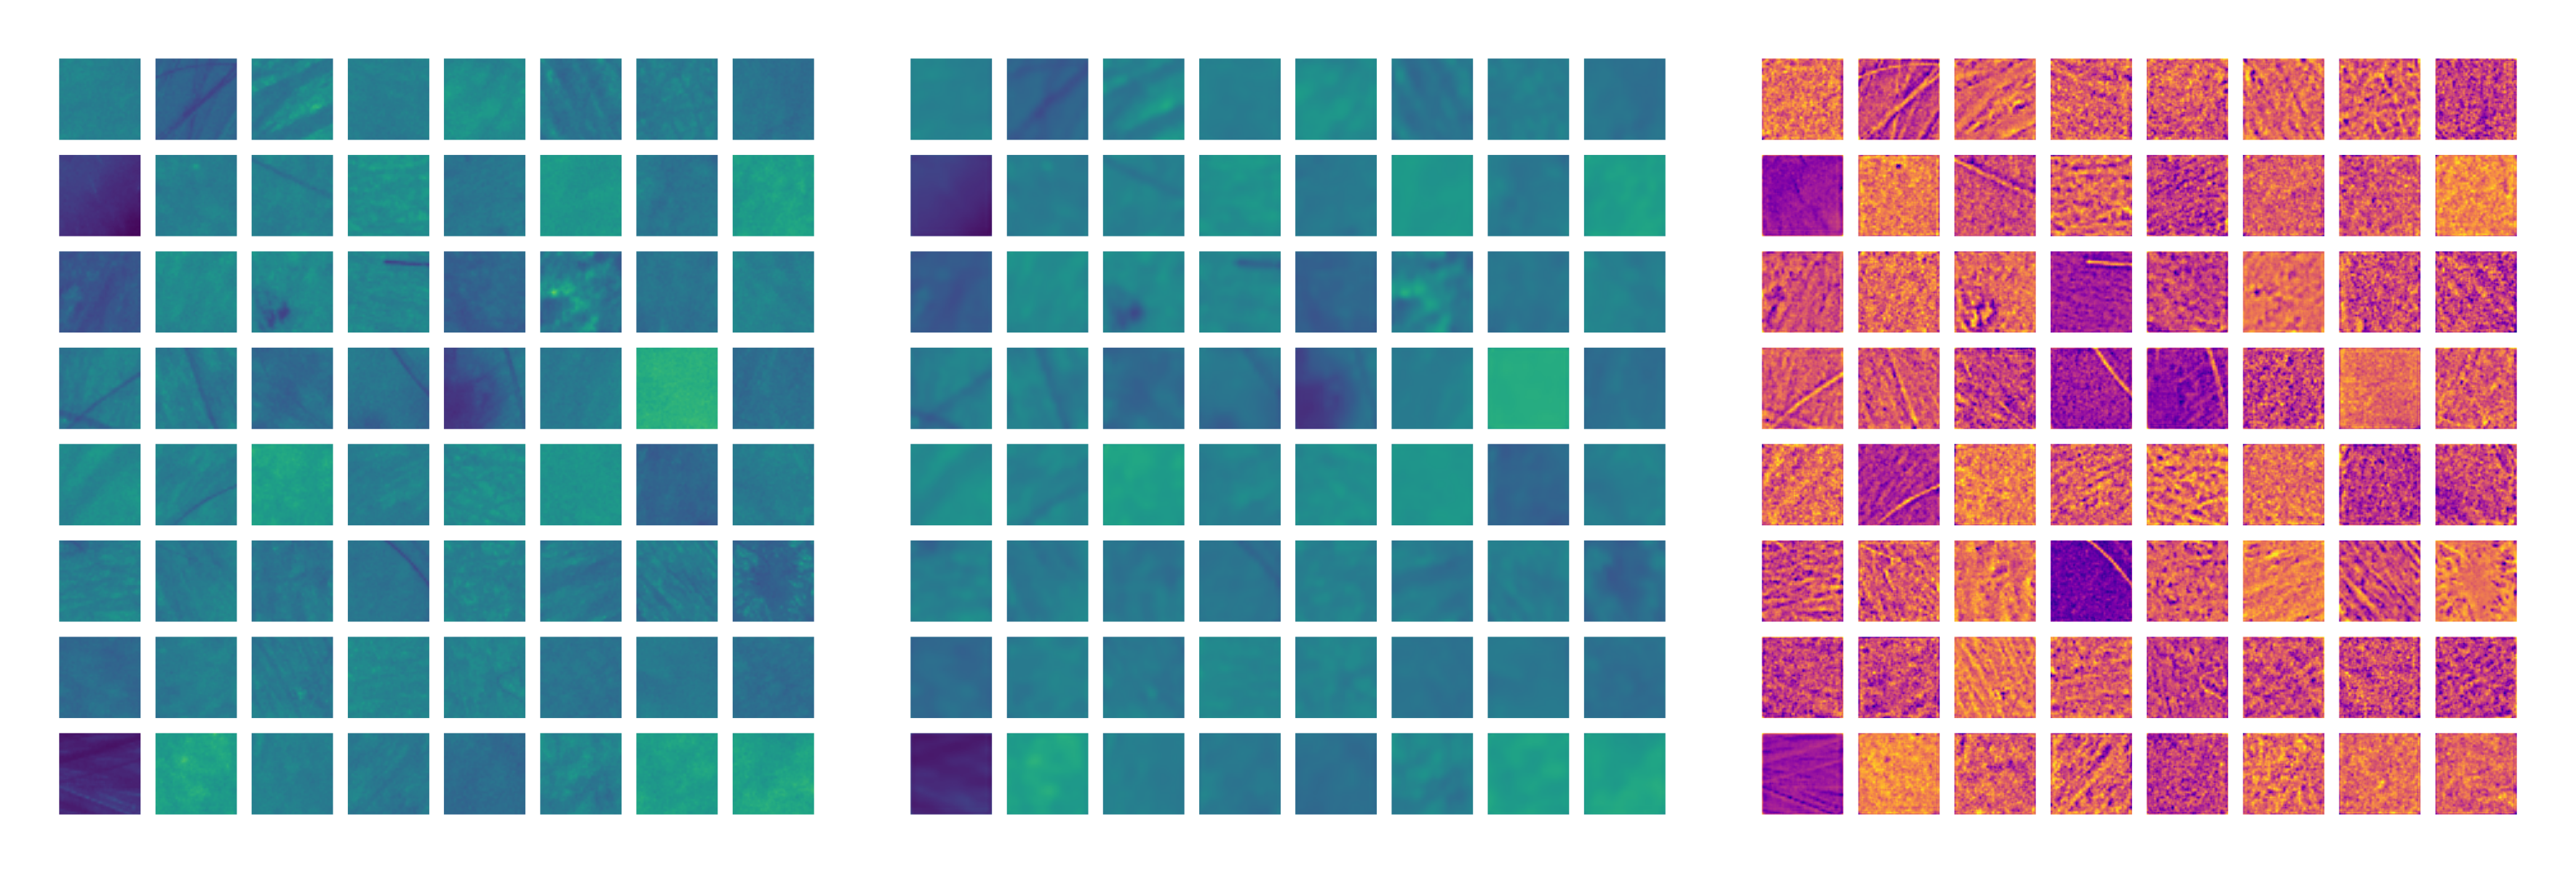

In [111]:
for batch_idx, (image, _) in enumerate(dataloader):
    if batch_idx == 1:
        break

    reconstructed_image = autoencoder(image)
    difference_image = reconstructed_image - image
            
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, dpi=600)
    show_image_grid(image, ax1)
    show_image_grid(reconstructed_image, ax2)
    show_image_grid(difference_image, ax3, vmin=None, vmax=None, cmap="plasma")
    fig.tight_layout()
    fig.savefig(str(output_dir / f"viz-{ckpt_file.stem}.pdf" ))